## **ABOUT**
This is an demo SE sequence based on pypulseq offical codes. Author: linkaisheng; email: linkaisheng@stu.pku.edu.cn

This example illustrates the 2D multi-slice, Spin Echo (SE) acquisition using the `pypulseq` library. This sequence is typically used for T<sub>2</sub> weighted imaging. A 2D Fourier transform can be used to reconstruct images from this acquisition. Read more about SE [here](http://mriquestions.com/se-vs-multi-se-vs-fse.html).

**Contact**: For issues, write to ks3621@columbia.edu

---

## **IMPORT PACKAGES**

In [10]:
from math import pi

import numpy as np

from pypulseq.Sequence.sequence import Sequence
from pypulseq.calc_duration import calc_duration
from pypulseq.make_adc import make_adc
from pypulseq.make_delay import make_delay
from pypulseq.make_sinc_pulse import make_sinc_pulse
from pypulseq.make_block_pulse import make_block_pulse
from pypulseq.make_trapezoid import make_trapezoid
from pypulseq.opts import Opts

## **USER INPUTS**

These parameters are typically on the user interface of the scanner computer console 

In [2]:
nsa = 1  # Number of averages
n_slices = 1  # Number of slices
Nx = 40
Ny = 40
fov = 150  # mm
slice_thickness = 0  # s
slice_gap = 0  # s
rf_flip = 90  # degrees
rf_offset = 0
print('User inputs setup - custom definition')

User inputs setup - custom definition


## **SYSTEM LIMITS**
Set the hardware limits and initialize sequence object using Josalggui's MaRGE hw parameters.

In [7]:
system = Opts(adc_dead_time=0,          # Dead time for ADC readout pulses.
    adc_raster_time=100e-9,             # Raster time for ADC readout pulses.
    block_duration_raster=20e-6,        # Raster time for block durations.
    gamma=42.576e6,                     # Gyromagnetic ratio. Default gamma is specified for Hydrogen.
    grad_raster_time=20e-6,             # Extreme limit is 5us but here we define 20us 
    grad_unit='mT/m',
    max_grad=80,                        # Maximum gradient amplitude.
    max_slew=50e-3,                     # Maximum slew rate.
    rf_dead_time=400e-6,                # Dead time for radio-frequency pulses.
    rf_raster_time=1/(1.2288e8),        # Raster time for radio-frequency pulses. Rf resolution is 1/(clock freqency).
    rf_ringdown_time=0,                 # Ringdown time for radio-frequency pulses.
    # adc_samples_limit=0,                # Maximum number of samples for a single ADC object. If 0, no limit is set.
    # adc_samples_divisor=1,              # Samples of ADC must be divisible by 'adc_samples_divisor'.
    rise_time=400e-6,                   # Rise time for gradients.
    slew_unit='mT/m/ms',
    B0=0.072                           # Main magnetic field strength (in tesla)
    )
seq = Sequence(system)

## **TIME CONSTANTS**

In [8]:
TE = 20e-3  # s
TR = 0.3  # s
tau = TE / 2  # s
readout_time = 2.5e-3 #s, readout gradient time?
pre_time = 1e-3  # s, readout prephasing time?

## **RF**

In [11]:
flip90 = round(rf_flip * pi / 180, 3)
flip180 = 180 * pi / 180
rf90, de90= make_block_pulse(flip_angle=flip90, 
                             system=system,
                             duration=35e-6, #s
                             freq_offset=0, #Hz
                             phase_offset=0, 
                             #time_bw_product=4,
                             return_delay= True
                            )


## **READOUT**
Readout gradients and related events

In [7]:
delta_k = 1 / fov
k_width = Nx * delta_k
gx = make_trapezoid(channel='x', system=system, flat_area=k_width, 
                    flat_time=readout_time)
adc = make_adc(num_samples=Nx, duration=gx.flat_time, delay=gx.rise_time)

## **PREPHASE AND REPHASE**

In [8]:
phase_areas = (np.arange(Ny) - (Ny / 2)) * delta_k
gz_reph = make_trapezoid(channel='z', system=system, area=-gz90.area / 2,
                         duration=2.5e-3)
gx_pre = make_trapezoid(channel='x', system=system, flat_area=k_width / 2, 
                        flat_time=readout_time / 2)
gy_pre = make_trapezoid(channel='y', system=system, area=phase_areas[-1], 
                        duration=2e-3)

## **SPOILER**

In [9]:
gz_spoil = make_trapezoid(channel='z', system=system, area=gz90.area * 4,
                          duration=pre_time * 4)

## **DELAYS**
Echo time (TE) and repetition time (TR). Here, TE is broken down into `delay1` and `delay2`.

In [10]:
delay1 = tau - calc_duration(rf90) / 2 - calc_duration(gx_pre)
delay1 -= calc_duration(gz_spoil) - calc_duration(rf180) / 2
delay1 = make_delay(delay1)
delay2 = tau - calc_duration(rf180) / 2 - calc_duration(gz_spoil)
delay2 -= calc_duration(gx) / 2
delay2 = make_delay(delay2)
delay_TR = TR - calc_duration(rf90) / 2 - calc_duration(gx) / 2 - TE
delay_TR -= calc_duration(gy_pre)
delay_TR = make_delay(delay_TR)
print(f'delay_1: {delay1}')
print(f'delay_2: {delay1}')
print(f'delay_TR: {delay_TR}')

delay_1: namespace(type='delay', delay=0.04281)
delay_2: namespace(type='delay', delay=0.04281)
delay_TR: namespace(type='delay', delay=2.8927250000000004)


## **CONSTRUCT SEQUENCE**
Construct sequence for one phase encode and multiple slices

In [11]:
# Prepare RF offsets. This is required for multi-slice acquisition
delta_z = n_slices * slice_gap
z = np.linspace((-delta_z / 2), (delta_z / 2), n_slices) + rf_offset

for k in range(nsa):  # Averages
  for j in range(n_slices):  # Slices
    # Apply RF offsets
    freq_offset = gz90.amplitude * z[j]
    rf90.freq_offset = freq_offset

    freq_offset = gz180.amplitude * z[j]
    rf180.freq_offset = freq_offset

    for i in range(Ny):  # Phase encodes
      seq.add_block(rf90, gz90)
      gy_pre = make_trapezoid(channel='y', system=system, 
                              area=phase_areas[-i -1], duration=2e-3)
      seq.add_block(gx_pre, gy_pre, gz_reph)
      seq.add_block(delay1)
      seq.add_block(gz_spoil)
      seq.add_block(rf180, gz180)
      seq.add_block(gz_spoil)
      seq.add_block(delay2)
      seq.add_block(gx, adc)
      gy_pre = make_trapezoid(channel='y', system=system, 
                              area=-phase_areas[-j -1], duration=2e-3)
      seq.add_block(gy_pre, gz_spoil)
      seq.add_block(delay_TR)

## **PLOTTING TIMNG DIAGRAM**

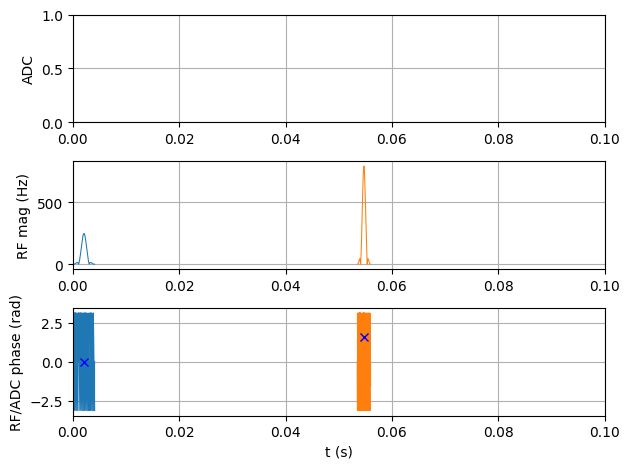

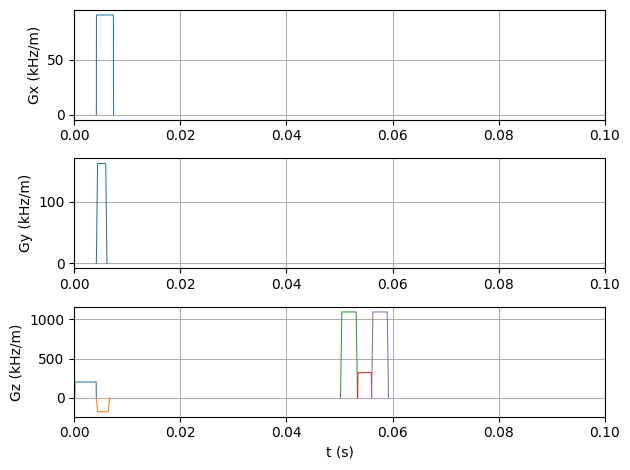

In [12]:
seq.plot(time_range=(0, 0.1))

## **GENERATING `.SEQ` FILE**
Uncomment the code in the cell below to generate a `.seq` file and download locally.

In [0]:
# seq.write('t2_se_pypulseq_colab.seq')  # Save to disk
# from google.colab import files
# files.download('t2_se_pypulseq_colab.seq')  # Download locally